# Import the packages

In [4]:
import pipeline as pi
from tifffile import imread,imwrite
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
from placozoan.func_segmentation import segmentation_chanvese,get_holes_mask
from placozoan.base_features import SingleObjectFeatures

# Preprocessing

## Steps:
    
    - Increase the contrast of the image 
    - Segmenting the algae plane per plane
    - Removing them from background

In [2]:
start = time.time()

In [3]:
preprocessed,alg_mask = pi.preprocessing('../data/tricho_8.tif')

Increasing the contrast...
--------------------------------------------------------------
Done with the contrast!
--------------------------------------------------------------
Segmenting the algae...
--------------------------------------------------------------
0.00 % done ...
0.29 % done ...
0.58 % done ...
0.87 % done ...
1.16 % done ...
1.45 % done ...
1.73 % done ...
2.02 % done ...
2.31 % done ...
2.60 % done ...
2.89 % done ...
3.18 % done ...
3.47 % done ...
3.76 % done ...
4.05 % done ...
4.34 % done ...
4.62 % done ...
4.91 % done ...
5.20 % done ...
5.49 % done ...
5.78 % done ...
6.07 % done ...
6.36 % done ...
6.65 % done ...
6.94 % done ...
7.23 % done ...
7.51 % done ...
7.80 % done ...
8.09 % done ...
8.38 % done ...
8.67 % done ...
8.96 % done ...
9.25 % done ...
9.54 % done ...
9.83 % done ...
10.12 % done ...
10.40 % done ...
10.69 % done ...
10.98 % done ...
11.27 % done ...
11.56 % done ...
11.85 % done ...
12.14 % done ...
12.43 % done ...
12.72 % done ...
13.01 

# Drift computation

## Steps:

### Computing the drift between each plane

In [4]:
dx, dy = pi.global_drift(alg_mask)

0.00 % done ...
0.29 % done ...
0.58 % done ...
0.87 % done ...
1.16 % done ...
1.45 % done ...
1.73 % done ...
2.02 % done ...
2.31 % done ...
2.60 % done ...
2.89 % done ...
3.18 % done ...
3.47 % done ...
3.76 % done ...
4.05 % done ...
4.34 % done ...
4.62 % done ...
4.91 % done ...
5.20 % done ...
5.49 % done ...
5.78 % done ...
6.07 % done ...
6.36 % done ...
6.65 % done ...
6.94 % done ...
7.23 % done ...
7.51 % done ...
7.80 % done ...
8.09 % done ...
8.38 % done ...
8.67 % done ...
8.96 % done ...
9.25 % done ...
9.54 % done ...
9.83 % done ...
10.12 % done ...
10.40 % done ...
10.69 % done ...
10.98 % done ...
11.27 % done ...
11.56 % done ...
11.85 % done ...
12.14 % done ...
12.43 % done ...
12.72 % done ...
13.01 % done ...
13.29 % done ...
13.58 % done ...
13.87 % done ...
14.16 % done ...
14.45 % done ...
14.74 % done ...
15.03 % done ...
15.32 % done ...
15.61 % done ...
15.90 % done ...
16.18 % done ...
16.47 % done ...
16.76 % done ...
17.05 % done ...
17.34 % done ..

### Filtering to find the moments the camera moved

In [5]:
df_drift,res = pi.filtering_drift(dx,dy)

# Visualizing the drift

In [ ]:
canva,diffx,diffy = pi.create_canva(df_drift,preprocessed)

rescaled = pi.place_img(canva,diffx,diffy,preprocessed,df_drift,res)

In [6]:
end = time.time() - start
print(f'The whole pipeline took {end/60:.2f} minutes to complete')

The whole pipeline took 3.52 minutes to complete


# Outputs

## Preprocessed image

In [ ]:
plane = 10
plt.imshow(preprocessed[plane,...])
plt.axis('off')
plt.show()

## Drift of the movie

In [ ]:
df_drift

### Visualization of the direction of the drift

In [ ]:
sns.scatterplot(data=df_drift,x="start",y='displacement',hue='coord')
plt.ylabel('Displacement (pixel)')
plt.xlabel('Start frame')
plt.legend(loc='upper center',title='Displaced coordinate')
plt.show()

## Rescaled image

In [ ]:
plt.imshow(rescaled[800,...])
plt.axis('off')
plt.show()

### Visualizing the full moovement

In [ ]:
plt.imshow(np.mean(rescaled,axis=0))
plt.axis('off')
plt.show()

# Saving the images

## Saving the preprocessed image

In [13]:
path_preprocessed = '../data/tricho_wound_preprocessed_otsu.tif'
imwrite(path_preprocessed,preprocessed)

## Saving the canva

In [14]:
path_canva = '../data/tricho_8_wound_drift_visualization.tif'
imwrite(path_canva,rescaled,compression='zlib') #adding compression to reduce file size

# Segmentation of the preprocessed movie

In [7]:
mask = segmentation_chanvese(preprocessed)

# Extracting the features

## Organism

In [5]:
mask = imread('../data/results/chan_vese/placozoan-movie_wound_masked_chanvese.tif')
preprocessed = imread('../data/results/chan_vese/placozoan-movie_wound_masked_chanvese.tif')

In [5]:
prop = {'properties': ['label',
   'centroid',
   'area',
   'perimeter',
   'eccentricity',
   'orientation',
   'axis_major_length',
   'axis_minor_length'],
  'extra_properties': ['convexity']}

segmentator = SingleObjectFeatures(mask,preprocessed, params=prop)
df_props = segmentator.get_features()

## Wound

In [6]:
wound = get_holes_mask(mask)
segmentator = SingleObjectFeatures(wound,wound, params=prop)
df_props_wound = segmentator.get_features()

In [7]:
df_props_wound = pi.filling_wound(df_props,df_props_wound,19)

In [8]:
df_props.to_csv('../data/results/figures/complete_pipeline/props_compare.csv')
df_props_wound.to_csv('../data/results/figures/complete_pipeline/props_wound_compare.csv')


In [ ]:
df_props_wound = pi.clean_resuls(df_props_wound,df_drift)

# Plotting results and extracting features

In [33]:
size_pixel=0.7692 #in microns

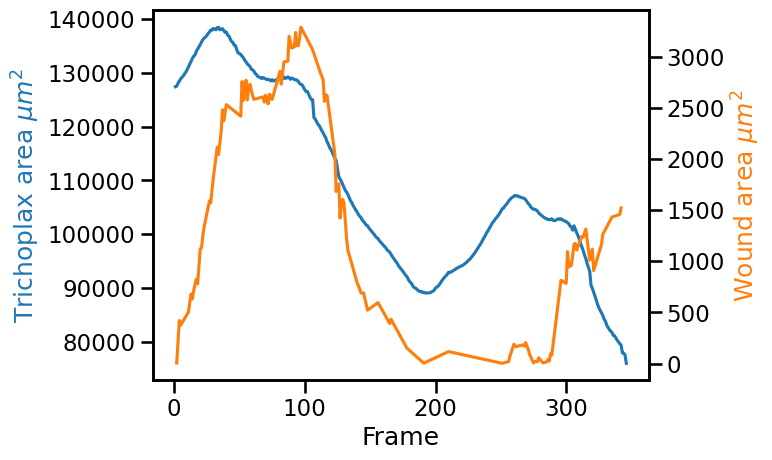

In [172]:
sns.set_context('talk')
fig,ax = plt.subplots()
ax2 = ax.twinx()

sns.lineplot(x=df_props.index.values,y = df_props.area*(size_pixel)*(size_pixel),ax = ax,color='tab:blue')
sns.lineplot(x=df_props_wound.index.values,y = df_props_wound.area*(size_pixel)*(size_pixel), ax = ax2,color='tab:orange')
ax.set_ylabel('Trichoplax area $\mu m^2$',color = 'tab:blue')
ax2.set_ylabel('Wound area $\mu m^2$',color='tab:orange')
ax.set_xlabel('Frame')
plt.show()

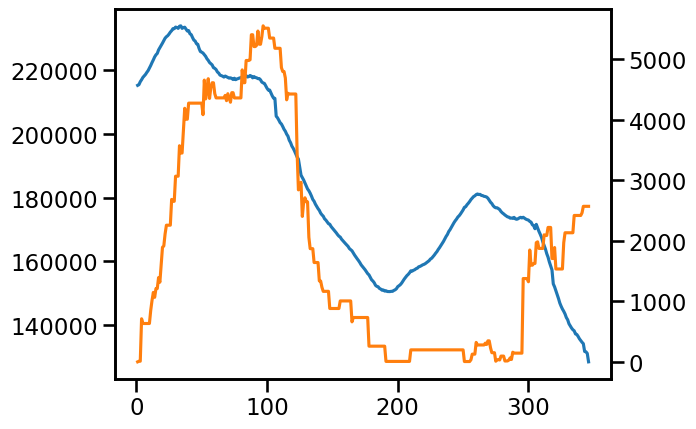

In [173]:
area_w = np.array((dft.values))
area_o = np.array((df_props.area.values))

fig,ax = plt.subplots()
ax2 = ax.twinx()

sns.lineplot(x=df_props.index.values,y = area_o,ax = ax,color='tab:blue')
sns.lineplot(x=dft.index.values,y = area_w , ax = ax2,color='tab:orange')

plt.show()

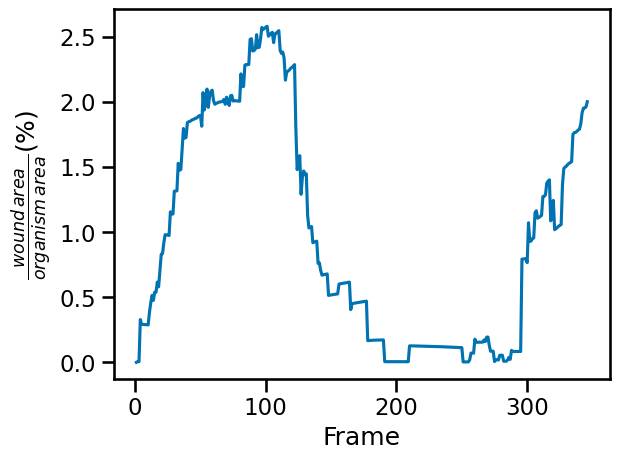

In [185]:
sns.lineplot(x = df_props.index.values,y = (area_w/area_o)*100)
plt.ylabel(r"$ \frac{wound\,area}{organism\,area}$" + '(%)')
plt.xlabel('Frame')
plt.show()

In [29]:
df_props_pipeline_wound = pd.read_csv('../data/results/figures/complete_pipeline/props_wound_pipeline.csv')

In [30]:
df_props_wound = pd.read_csv('../data/results/figures/complete_pipeline/props_wound_compare.csv')

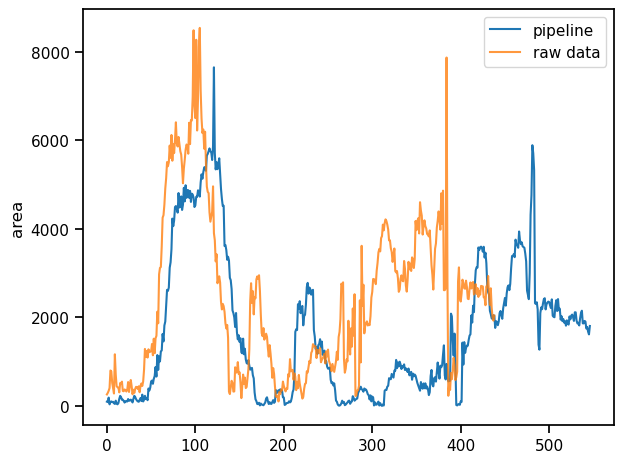

In [54]:
fig,ax = plt.subplots()
sns.set_context('notebook')
sns.lineplot(df_props_pipeline.area,ax=ax,label="pipeline")
sns.lineplot(df_props.area,ax=ax,alpha=0.8,label='raw data')
plt.tight_layout()
#plt.savefig('../data/results/figures/complete_pipeline/wound_area_compared.png',dpi=300)

plt.show()

In [31]:
time_wound = len(df_props_wound.index)
time_wound_pipeline = len(df_props_pipeline_wound.index)

In [34]:
print(f'The pipeline allowed to see the wound {time_wound_pipeline/time_wound:.2f} times more')

The pipeline allowed to see the wound 1.25 times more


In [6]:
df_props_pipeline = pd.read_csv('../data/results/figures/complete_pipeline/props_corrected_pipeline.csv')
df_props = pd.read_csv('../data/results/figures/complete_pipeline/props_compare.csv')

## Try interpolation

In [180]:
def interpolate_wound(df_wound,df_org,laser,names = ['area','centroid-0','centroid-1','perimeter'],degree= 3):
    '''
    Parameters
    ----------
    df_wound : Dataframe
        Dataframe containing the wound properties
    df_org : Dataframe
        Dataframe containing the organism properties.
    laser : int
        plane where there is the laser.
    names : list, optional
        the list of the columns you want to interpolate. The default is ['area','centroid-0','centroid-1','perimeter'].

    Returns
    -------
    dft_n : Dataframe
        Dataframe containing the interpolated values for the columns selected.
    '''
    
    x = df_wound.label.values
    real_x = df_org.label.values

    res = []

    for i in names:
        y = df_wound[i].values   #gather the values
        spl = InterpolatedUnivariateSpline(x, y ,k=degree) #compute the interpolation function
        res.append(spl(real_x)) #append the interpolated values to list 
    
    dft_n = pd.DataFrame(res).T
    dft_n = dft_n.set_axis(names,copy = False , axis=1)
    
    for i in dft_n.index.values: # replace the values before the laser by 0 (there should not be a wound before)
        if i < laser:
            dft_n.loc[i,:] = 0

    return dft_n

In [181]:
dft_n = interpolate_wound(df_wound,df_props_pipeline_complete,laser = 18)

<AxesSubplot:ylabel='area'>

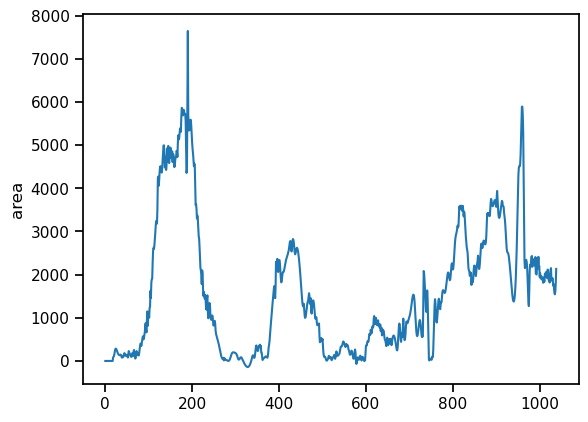

In [189]:
sns.lineplot(data=dft_n,x=dft_n.index.values,y='area')